In [1]:
##November 6 2023
#File to address major revision to paper Classifying ransomware-Bitcoin nodes using graph embeddings
##
#Install required packages
# Install Python packages required for the notebook
import sys
!{sys.executable} -m pip install -U scikit-learn
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install altair
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install -U matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [48]:
##Import pacakges
import pandas as pd
#import sklearn 
#as scikit_learn
import scipy
import altair as alt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix



In [3]:
##Source File containing embeddings from Neo4j Graph
#Data source is the Wannacry cashout network from address: 12t9YDP
##Should we test other networks and add a section on this?
##It means I would need to load other graphs into neo4j and get their embeddings
#fileName = '' ##13am4v cash-out network
#fileName = '' ##115p7u cash-out network
fileName = '20231101-GraphSage-relu' ##12t9yd cash-out network

In [4]:
##Read the source file into a pandas dataframe 
d = pd.read_csv('/Users/abt/Downloads/'+fileName+'.csv')

##Strip the dataframe column 'features' which contains the embeddings into individual columns 
nd = d['features'].str.strip('[]').str.split(',').apply(pd.Series)

##Assign to dataframe X
X=nd

##Dataframe of original csv file
print(d.head())

##Dataframe of flattened features (embeddings) column
print(X.head())

                                                name       exp        pr  \
0  3332d270983f3183af866714b8eb4ad226f4f4bea2ce42...  0.108562  1.095921   
1  6fc639ba056de897d32c26cc2f5a917dfb38256eef5e92...  0.007299  1.187965   
2  5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...  0.012479  0.422965   
3  c371eb6820214043060538ef4f79b796607c63f73b9a74...  0.094085  0.853949   
4  131551e35e7a644b76ea5366f744313bff3f959207c416...  0.518371  1.305228   

   outdeg  indeg         ta            ts  \
0       2      4  15.850084  1.501849e+12   
1       1      7   0.799231  1.501909e+12   
2       2      1   3.643837  1.501752e+12   
3       1      4  16.483686  1.501852e+12   
4       2      5  64.870398  1.501851e+12   

                                            features  
0  [0.0976068716032347, -0.0004806914493912979, 0...  
1  [-0.0003116965729766629, -0.000180858744148451...  
2  [-0.000398115961121179, -0.0003733035777815432...  
3  [-0.0002324438808046707, -0.000168763554879967...

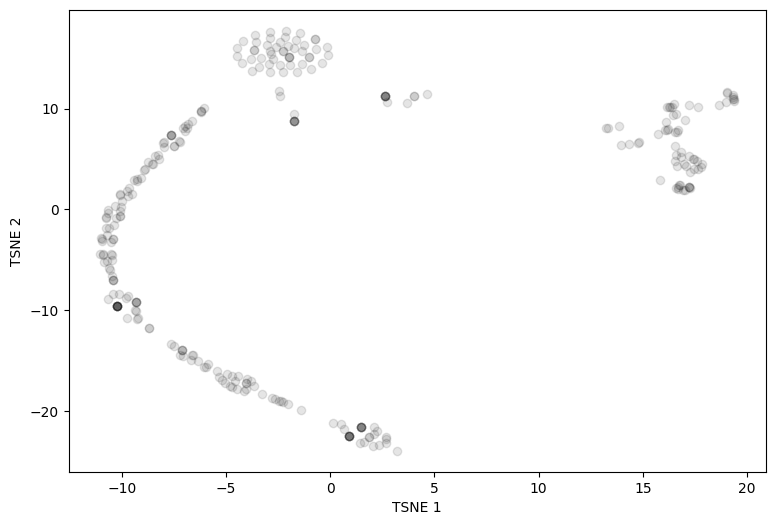

In [5]:
##Dimensionality Reduction
##T-SNE
#Reduce dimensionality to 2 components using T-SNE method from the embeddings dataframe 'X'
X_tsne = TSNE(n_components=2, random_state=6).fit_transform(X)
#Write these 2 dimensions to a new dataframe TSNE
TSNE_components = pd.DataFrame(X_tsne, columns=['X_red_X', 'X_red_Y'])
#Build the TSNE dataframe up with the other columns associated with the embeddings
##CHANGE THE COLUMN NAMES TO BE MORE MEANINGFUL MAKES WRITE UP EASIER
TSNE_components['btc_id']=d['name']
TSNE_components['risk_rating']=d['exp']
TSNE_components['pageRank']=d['pr']
TSNE_components['out_deg']=d['outdeg']
TSNE_components['in_deg']=d['indeg']
TSNE_components['total_amount']=d['ta']

##Plot the TSNE to determine if there are any clear clusters
plt.figure(figsize=(9 ,6))
plt.scatter(TSNE_components['X_red_X'], TSNE_components['X_red_Y'], alpha=.1, color='black')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()


In [6]:
print(TSNE_components.head())

     X_red_X    X_red_Y                                             btc_id  \
0  14.828122   6.701016  3332d270983f3183af866714b8eb4ad226f4f4bea2ce42...   
1  19.313627  10.912021  6fc639ba056de897d32c26cc2f5a917dfb38256eef5e92...   
2  16.997747   8.859790  5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...   
3  16.589445   9.413855  c371eb6820214043060538ef4f79b796607c63f73b9a74...   
4  13.873098   8.235876  131551e35e7a644b76ea5366f744313bff3f959207c416...   

   risk_rating  pageRank  out_deg  in_deg  total_amount  
0     0.108562  1.095921        2       4     15.850084  
1     0.007299  1.187965        1       7      0.799231  
2     0.012479  0.422965        2       1      3.643837  
3     0.094085  0.853949        1       4     16.483686  
4     0.518371  1.305228        2       5     64.870398  


In [7]:
##Interactive plot of embeddings and associated graph properties
alt.Chart(TSNE_components).mark_circle(size=60).encode(
    x='X_red_X',
    y='X_red_Y',
    size='pageRank',
    color='risk_rating',
    tooltip=['btc_id', 'total_amount', 'out_deg', 'in_deg', 'risk_rating']
).interactive()

alt.Chart(...)

In [8]:
##Show the distribution of one of the components (X_red_X) in the TSNE dataset
##Using binning to bucket the values into their respective cohorts
####DOUBLE CHECK THIS RATIONALE
##This helps show the utility of the feature. A more distributed feature is more diverse
##a more conentrated feature is less representative of the whole dataset
alt.Chart(TSNE_components).mark_bar().encode(
    alt.X("X_red_X", bin=True),
    y='count()',
).interactive()
#alt.Bin(extent=[0,1], step=0.05)
#sns.displot(TSNE_components, x="risk_rating")
#plt.show()

alt.Chart(...)

(7.5, -0.5)

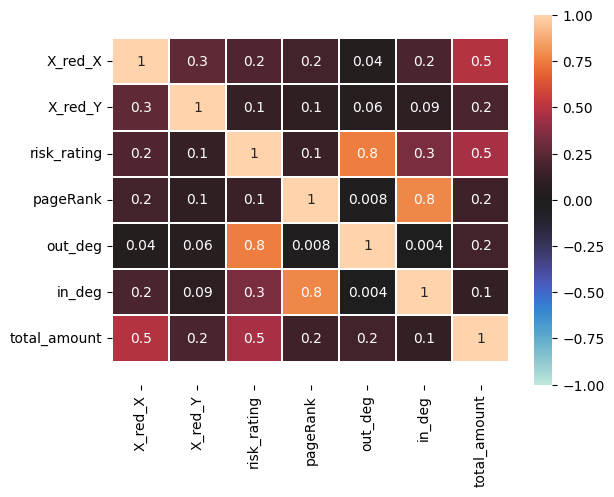

In [9]:
##Using the correlation/heatmap method to show the relationship between features of the dataset
##Strongly positively correlated features (>0.6) suggest good features to use
corr = TSNE_components.corr(numeric_only=True)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0)
ax = sns.heatmap(corr, annot = True, fmt='.1g', linewidths=.2, vmin=-1, vmax=1, center= 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

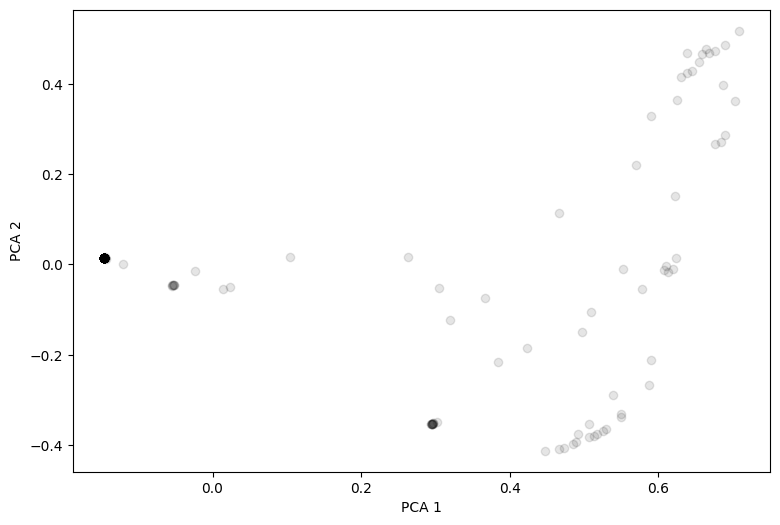

    X_red_X   X_red_Y                                             btc_id  \
0  0.509495 -0.105738  3332d270983f3183af866714b8eb4ad226f4f4bea2ce42...   
1  0.639226  0.468174  6fc639ba056de897d32c26cc2f5a917dfb38256eef5e92...   
2  0.569814  0.221482  5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...   
3  0.684332  0.271776  c371eb6820214043060538ef4f79b796607c63f73b9a74...   
4  0.466946  0.114084  131551e35e7a644b76ea5366f744313bff3f959207c416...   

   risk_rating  pageRank  out_deg  in_deg  total_amount  
0     0.108562  1.095921        2       4     15.850084  
1     0.007299  1.187965        1       7      0.799231  
2     0.012479  0.422965        2       1      3.643837  
3     0.094085  0.853949        1       4     16.483686  
4     0.518371  1.305228        2       5     64.870398  


In [10]:
##Dimensionality Reduction
##PCA
#Reduce dimensionality to 2 components using PCA method from the embeddings dataframe 'X'

#Reduce the components to 2
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

# Save components to a DataFrame
##CHANGE THE COLUMN NAMES TO BE MORE MEANINGFUL MAKES WRITE UP EASIER
PCA_components = pd.DataFrame(X_pca, columns=['X_red_X', 'X_red_Y'])
PCA_components['btc_id']=d['name']
PCA_components['risk_rating']=d['exp']
PCA_components['pageRank']=d['pr']
PCA_components['out_deg']=d['outdeg']
PCA_components['in_deg']=d['indeg']
PCA_components['total_amount']=d['ta']

plt.figure(figsize=(9 ,6))
#Plot the PCA to determine if there are any clear clusters
plt.scatter(PCA_components['X_red_X'], PCA_components['X_red_Y'], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()
print(PCA_components.head())

In [11]:
##Interactive plot of embeddings and associated graph properties
alt.Chart(PCA_components).mark_circle(size=60).encode(
    x='X_red_X',
    y='X_red_Y',
    size='pageRank',
    color=alt.Color('risk_rating', scale=alt.Scale(scheme='turbo')),
    tooltip=['btc_id', 'total_amount', 'out_deg', 'in_deg', 'risk_rating']
).interactive()

alt.Chart(...)

In [12]:
##Show the distribution of one of the components (X_red_X) in the PCA dataset
##Using binning to bucket the values into their respective cohorts
####DOUBLE CHECK THIS RATIONALE
##This helps show the utility of the feature. A more distributed feature is more diverse
##a more conentrated feature is less representative of the whole dataset
alt.Chart(PCA_components).mark_bar().encode(
    alt.X("X_red_X", bin=True),
    y='count()',
).interactive()
#alt.Bin(extent=[0,1], step=0.05)
#sns.displot(TSNE_components, x="risk_rating")
#plt.show()

alt.Chart(...)

(7.5, -0.5)

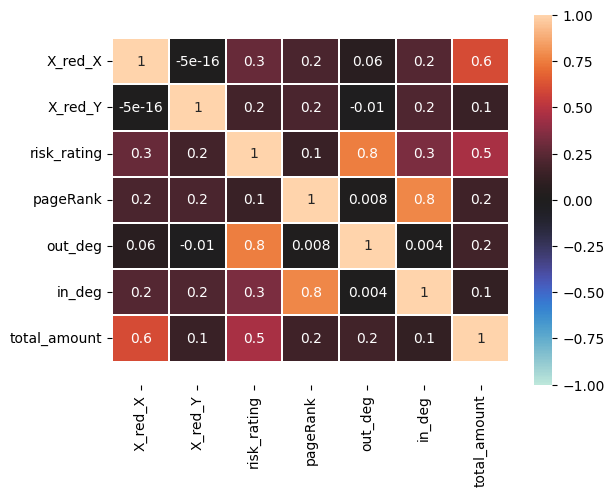

In [13]:
##Using the correlation/heatmap method to show the relationship between features of the dataset
##Strongly positively correlated features (>0.6) suggest good features to use
corr = PCA_components.corr(numeric_only=True)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0)
ax = sns.heatmap(corr, annot = True, fmt='.1g', linewidths=.2, vmin=-1, vmax=1, center= 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [14]:
"""
Elbow Method
Determining the ideal number of clusters for our k-means model can be done by measuring
the sum of the squared distances to the nearest cluster center aka inertia.
"""
#X_pca - is for PCA
#X_tsne - is for t-sne
def elbow_fn(X_tsne):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters=k)
        
        # Fit model to samples
        model.fit(X_tsne)
        
        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)
        
    plt.plot(ks, inertias, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    return



/Users/abt/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/abt/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/abt/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/abt/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will c

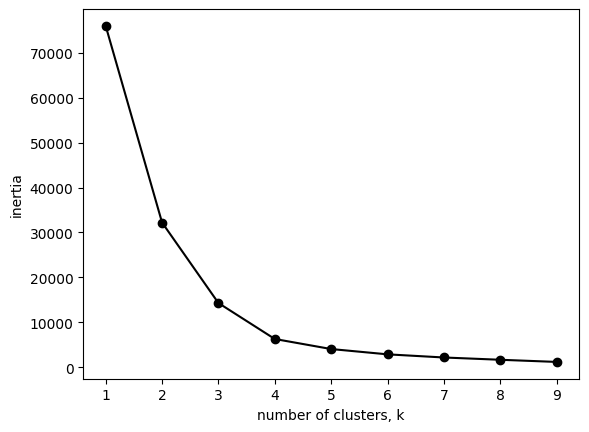

In [15]:
##Run Elbow function to determine the number of clusters (K) for analysis 
#using the PCA fit
#elbow_fn(X_pca)

#using the TSNE fit
elbow_fn(X_tsne)

In [16]:
##Determine Kmeans clustering
##K is determined from the 'elbow' graph at the minimum point
K=4
#X_pca - PCA
#X_tsne - TSNE
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_tsne)
#Cluster labels
lab = kmeans.labels_

#print("*****Cluster Centers*****")
#print(kmeans.cluster_centers_)
centers = kmeans.cluster_centers_


/Users/abt/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
#output routine 
#X_pca - PCA
#X_tsne - t-sne
d2 = d.assign(X_red_X=X_tsne[:,0], X_red_Y=X_tsne[:,1], cluster_label=lab)
#d3 = d2.assign(X_red_Y=X_red[:,1])
#print("D2")
#print(d2)
#Output analysis data set to CSV
print(d2.head())
#d2.to_csv("/Users/abt/Downloads/"+fileName+"_output_tsne_1.csv")

                                                name       exp        pr  \
0  3332d270983f3183af866714b8eb4ad226f4f4bea2ce42...  0.108562  1.095921   
1  6fc639ba056de897d32c26cc2f5a917dfb38256eef5e92...  0.007299  1.187965   
2  5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...  0.012479  0.422965   
3  c371eb6820214043060538ef4f79b796607c63f73b9a74...  0.094085  0.853949   
4  131551e35e7a644b76ea5366f744313bff3f959207c416...  0.518371  1.305228   

   outdeg  indeg         ta            ts  \
0       2      4  15.850084  1.501849e+12   
1       1      7   0.799231  1.501909e+12   
2       2      1   3.643837  1.501752e+12   
3       1      4  16.483686  1.501852e+12   
4       2      5  64.870398  1.501851e+12   

                                            features    X_red_X    X_red_Y  \
0  [0.0976068716032347, -0.0004806914493912979, 0...  14.828122   6.701016   
1  [-0.0003116965729766629, -0.000180858744148451...  19.313627  10.912021   
2  [-0.000398115961121179, -0.00037330

In [18]:
##Interactive chart
##KMEANS CLUSTER PLOT
alt.Chart(d2).mark_circle(size=60).encode(
    x='X_red_X',
    y='X_red_Y',
    size='pr',
    color=alt.Color('cluster_label', scale=alt.Scale(scheme='turbo')),
    tooltip=['name', 'ta', 'outdeg', 'indeg', 'exp']
).interactive()

alt.Chart(...)

(9.5, -0.5)

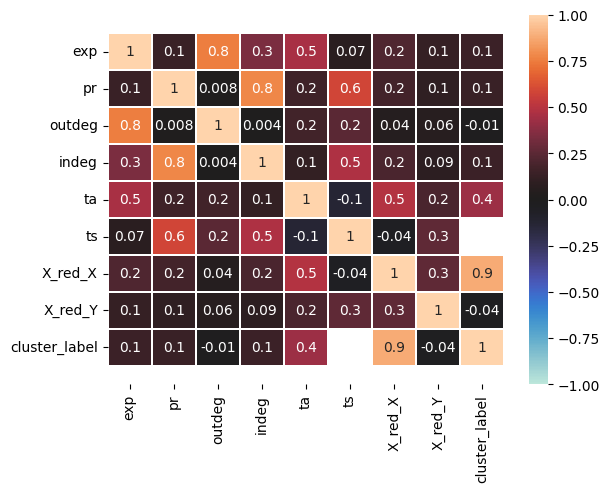

In [19]:
##Full set of feature correlation
##POTENTIALLY CHANGE COLUMNS NAMES TO BE MORE MEANINGFUL
corr = d2.corr(numeric_only=True)
#sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0)
ax = sns.heatmap(corr, annot = True, fmt='.1g', linewidths=.2, vmin=-1, vmax=1, center= 0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

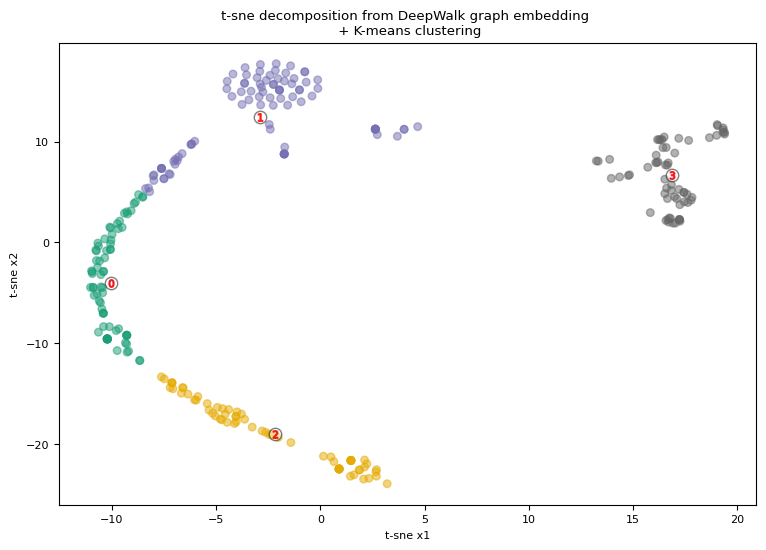

In [43]:
##PLOT K-MEANS CLUSTERING OF THE REDUCED DIMENSION OF EMBEDDINGS
##MAKE THE PLOT CLEARER REMOVE GRID and UPDATE COLOUR CODE
#X_pca - PCA
#X_tsne - t-sne

plt.figure(figsize=(9 ,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=lab, cmap='Dark2', s=30, alpha=0.5)

#plt.xlabel("PCA x1")
#plt.ylabel("PCA x2")
#plt.title("PCA decomposition from DeepWalk graph embedding \n + K-means clustering")

plt.xlabel("t-sne x1")
plt.ylabel("t-sne x2")
plt.title("t-sne decomposition from DeepWalk graph embedding \n + K-means clustering")

plt.rc('font', size=8)
#plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=0.5, s=80, edgecolor='k')
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, s=30, alpha=0.8, edgecolor='r')

#plt.grid()
plt.show()

In [60]:
##THIS SECTION NEEDS FIXING
##THIS IS THE PREDICTOR
##WE NEED TO BREAK UP THE DATA INTO TEST, TRAIN & VALIDATION
##WE NEED TO TEST DIFFERENT FEATURES FOR ABLATION STUDY
##WE NEED TO SET UP F1 SCORES + PRECISION + RECALL (OTHER METRICS?)
##Metrics and scoring: quantifying the quality of predictions
# https://scikit-learn.org/stable/modules/model_evaluation.html 
##BREAK CODE INTO MORE SECTIONS

##Setting up test and training data

#df = pd.DataFrame(np.random.randn(100, 2))
msk = np.random.rand(len(d2)) < 0.8
train = d2[msk]
test = d2[~msk]
print("***************")
print("Test data length")
print(len(test))
print("***************")
print("Train data length")
print(len(train))
print("***************")
print("Test dataset")
print("***************")
print(test.head(3))
print("***************")
print("Train dataset")
print("***************")
print(train.head(3))

***************
Test data length
66
***************
Train data length
233
***************
Test dataset
***************
                                                name       exp        pr  \
2  5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...  0.012479  0.422965   
3  c371eb6820214043060538ef4f79b796607c63f73b9a74...  0.094085  0.853949   
9  c7eb28c30d8b23e0612b1678a2ca1cd879655eda3e9f19...  0.000592  0.712078   

   outdeg  indeg         ta            ts  \
2       2      1   3.643837  1.501752e+12   
3       1      4  16.483686  1.501852e+12   
9       1      1   0.259428  1.501749e+12   

                                            features    X_red_X   X_red_Y  \
2  [-0.000398115961121179, -0.0003733035777815432...  16.997747  8.859790   
3  [-0.0002324438808046707, -0.000168763554879967...  16.589445  9.413855   
9  [0.08997382783535245, 0.009993522896696215, 0....  17.782053  4.185829   

   cluster_label  
2              3  
3              3  
9              3  
**********

In [61]:
##THIS SECTION NEEDS FIXING
##THIS IS THE PREDICTOR
##WE NEED TO BREAK UP THE DATA INTO TEST, TRAIN & VALIDATION
##WE NEED TO TEST DIFFERENT FEATURES FOR ABLATION STUDY
##WE NEED TO SET UP F1 SCORES + PRECISION + RECALL (OTHER METRICS?)
##Metrics and scoring: quantifying the quality of predictions
# https://scikit-learn.org/stable/modules/model_evaluation.html 
##BREAK CODE INTO MORE SECTIONS


##Label Encoder
le = preprocessing.LabelEncoder()
train['features'] = le.fit_transform(train['features'])
train['cluster_label'] = le.fit_transform(train['cluster_label'])

test['features'] = le.fit_transform(test['features'])
test['cluster_label'] = le.fit_transform(test['cluster_label'])

### Train the SGD classifier
log = MultiOutputClassifier(SGDClassifier(loss="log_loss"), n_jobs=10)
#lb = preprocessing.LabelBinarizer()
#y_onehot = lb.fit_transform(y)
#clf.fit(X, y_onehot)
#log.fit(x_train.reshape(-1, 1), y_train)
log.fit(train[['features']], train[['cluster_label']])


# Metrics and scoring: quantifying the quality of predictions

print("****F1 Score****")
print(f1_score(test[['cluster_label']], 
               log.predict(test[['features']]), average="micro"))
print("************************")

print("****Accuracy Score****")
print(accuracy_score(test[['cluster_label']], 
               log.predict(test[['features']])))
print("************************")

print("****Precision Score****")
print(precision_score(test[['cluster_label']], 
               log.predict(test[['features']]), average="micro"))
print("************************")

print("****Recall Score****")
print(recall_score(test[['cluster_label']], 
               log.predict(test[['features']]), average="micro"))
print("************************")

#print("****RoC AuC Score****")
#print(roc_auc_score(test[['cluster_label']], 
#               log.predict(test[['features']]), multi_class="ovo"))
#print("************************")



print("****Predicted Labels****")
#print(log.predict(test[['features']]))
#df_total["pred_lin_regr"] = clf.predict(Xtest) 
test['predicted_cluster_label'] = log.predict(test[['features']])
print(test[['name', 'exp', 'cluster_label','predicted_cluster_label']].head(20))
dx = test[['name', 'exp', 'cluster_label','predicted_cluster_label']]
dx.to_csv("/Users/abt/Downloads/"+fileName+"_output_predictor_tsne_2.csv")

/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/749902531.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['features'] = le.fit_transform(train['features'])
/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/749902531.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cluster_label'] = le.fit_transform(train['cluster_label'])
/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/749902531.py:16: SettingWithCopyWarning: 
A value is trying to be set

****F1 Score****
0.25757575757575757
************************
****Accuracy Score****
0.25757575757575757
************************
****Precision Score****
0.25757575757575757
************************
****Recall Score****
0.25757575757575757
************************
****Predicted Labels****
                                                 name       exp  \
2   5c181889994d707ee0a237ecf62efb53d532aa2b6077bf...  0.012479   
3   c371eb6820214043060538ef4f79b796607c63f73b9a74...  0.094085   
9   c7eb28c30d8b23e0612b1678a2ca1cd879655eda3e9f19...  0.000592   
12  29779df2e2a5a1f823b22e7e974a0082bdfd389edc1c11...  0.434600   
14  c03e48ad9fc778170c86542c0414a89052b21679a35761...  0.001188   
15  340b44c7a7857e36f81b2e8ba713911ea93e82afde6ea5...  0.059693   
19                 1CZH527GEeR5WDyGac5WHrD6tnW5qJkFGR  0.007523   
23                 1NXF5p5cbPgzKE9rrMbTCiwhKLWVQkN5FL  0.000070   
25                 1KhR4TW2d4cuDzfdXs2H57WKuVAmPca8zM  0.000088   
28                 13o5rKbr74wnaSANaMwWW

/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/749902531.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_cluster_label'] = log.predict(test[['features']])


In [62]:
##Calculating TP and FP from the confusion matrix

cnf_matrix = confusion_matrix(test[['cluster_label']], 
               log.predict(test[['features']]))
print(cnf_matrix)


[[ 0  0 15  0]
 [ 0  0 21  0]
 [ 0  0 17  0]
 [ 0  0 13  0]]


In [63]:

##Calculating TP and FP from the confusion matrix

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

print("False Postives")
print(FP)

print("False Negatives")
print(FN)

print("True Postives")
print(TP)

print("True Negatives")
print(TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True Postive Rate")
print(TPR)


# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True Negative Rate")
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive Predictive Value")
print(PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predictive Value")
print(NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Postive Rate")
print(FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate")
print(FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False Discovery Rate")
print(FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy")
print(ACC)


False Postives
[ 0.  0. 49.  0.]
False Negatives
[15. 21.  0. 13.]
True Postives
[ 0.  0. 17.  0.]
True Negatives
[51. 45.  0. 53.]
True Postive Rate
[0. 0. 1. 0.]
True Negative Rate
[1. 1. 0. 1.]
Positive Predictive Value
[       nan        nan 0.25757576        nan]
Negative Predictive Value
[0.77272727 0.68181818        nan 0.8030303 ]
False Postive Rate
[0. 0. 1. 0.]
False Negative Rate
[1. 1. 0. 1.]
False Discovery Rate
[       nan        nan 0.74242424        nan]
Overall Accuracy
[0.77272727 0.68181818 0.25757576 0.8030303 ]


/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/1765833671.py:37: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/1765833671.py:42: RuntimeWarning: invalid value encountered in divide
  NPV = TN/(TN+FN)
/var/folders/r9/vvxl3kt150x1qbv1f65wtgyc0000gn/T/ipykernel_45905/1765833671.py:57: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)
